### In this version:
- used validation set to choose best parameter
- use feature importance to drop features with low importance
- use oob score as reference to drop highly correlated reatures
- run xgboost with full set of features(parameters tuned in LR-XGB notebook
- run random forest with selected features

In [254]:
import pandas as pd
import numpy as np
import warnings
import xgboost as xgb
warnings.filterwarnings("ignore")

In [255]:
train = pd.read_csv('../data/train-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)
test=pd.read_csv('../data/test-no-label-parking.csv', parse_dates=[[3,4]], infer_datetime_format=True)
valid_swhg = pd.read_csv('../data/valid_swhg.csv', infer_datetime_format=True, index_col='index').set_index('index.1')

In [256]:
parkrec = pd.read_csv('../data/park_tojoin.csv')

In [257]:
pr_test=pd.read_csv('../data/park_tojoin_test.csv')

In [258]:
train['daily_mean_freq'] = parkrec['daily_avg_freq']
train['dow_mean_freq'] = parkrec['dow_avg_freq']

In [259]:
test['daily_mean_freq'] = pr_test['daily_avg_freq']
test['dow_mean_freq'] = pr_test['dow_avg_freq']

In [260]:
test.head()

,Date_Time,Street,From,To,Street.Length,daily_mean_freq,dow_mean_freq
0,2014-03-28 16:34:00,Stockton Street,Stockton Tunnel,Stockton Street,35.786472,17.900000,18.666667
1,2014-03-28 21:34:00,Van Ness Avenue,Hayes Street,Van Ness Avenue,63.787968,18.434783,25.333333
2,2014-03-28 19:50:00,Van Ness Avenue,McAllister Street,Van Ness Avenue,56.007236,44.050000,58.666667
3,2014-03-28 20:02:00,Mission Street,11th Street,Mission Street,139.651900,38.000000,47.000000
4,2014-03-28 19:43:00,Hyde Street,Golden Gate Avenue,McAllister Street,105.144110,91.333333,98.666667


##### Get the proper train and validation set

In [261]:
train_swhg = train[~train.index.isin(valid_swhg.index)]
valid_swhg = train[train.index.isin(valid_swhg.index)]

## Run with validation set to select features and hyper-parameters

In [262]:
# get long and lat for train street
st_latlng = pd.read_csv("../data/train_longlat.csv", index_col = False,  dtype = {'lat':np.float64,'lng':np.float64})

In [263]:
train_swhg = pd.merge(train_swhg,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])
valid_swhg= pd.merge(valid_swhg,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])

In [264]:
# sensor related data
sensor = pd.read_csv('../data/aggregated_sensor.csv')

In [265]:
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY']/100
sensor['TIME_OF_DAY'] = sensor['TIME_OF_DAY'].astype('int')

In [266]:
valid_swhg.head()

,Date_Time,Street,From,To,Real.Spots,Street.Length,any_spot,daily_mean_freq,dow_mean_freq,lat,lng
0,2014-01-18 20:39:00,Van Ness Avenue,Geary Boulevard,Myrtle Street,0,52.517840,0,35.090909,43.333333,37.785660,-122.421476
1,2014-01-18 20:22:00,Pine Street,Polk Street,Van Ness Avenue,0,139.494200,0,119.772727,149.000000,37.789637,-122.420507
2,2014-01-18 20:20:00,Larkin Street,Myrtle Street,Geary Street,0,52.188343,0,35.050000,27.333333,37.785650,-122.418024
3,2014-01-21 17:35:00,23rd Street,Mission Street,Bartlett Street,1,96.037110,1,144.409091,154.250000,37.753846,-122.418619
4,2014-01-27 19:03:00,Van Ness Avenue,Van Ness Avenue,Bush Street,0,39.027992,0,111.090909,121.333333,37.788499,-122.421892


In [267]:
# Clustering
from sklearn.cluster import KMeans
spots = np.vstack(train_swhg[['lat','lng']].values)
kmeans = KMeans().fit(spots)
train_swhg['street_cluster'] = kmeans.predict(train_swhg[['lat', 'lng']])
valid_swhg['street_cluster'] = kmeans.predict(valid_swhg[['lat', 'lng']])

In [268]:
# Time features
train_swhg['Minute'] = train_swhg.Date_Time.dt.minute
valid_swhg['Minute'] = pd.to_datetime(valid_swhg['Date_Time']).dt.minute
train_swhg['Hour'] = train_swhg.Date_Time.dt.hour
valid_swhg['Hour'] = pd.to_datetime(valid_swhg['Date_Time']).dt.hour
train_swhg['Dow'] = train_swhg.Date_Time.dt.weekday
valid_swhg['Dow'] = pd.to_datetime(valid_swhg['Date_Time']).dt.weekday

In [269]:
# Convert the time (Hour, Minute) to a numerical value XXXX
train_swhg['Time'] = train_swhg["Hour"]*100 + train_swhg['Minute']
valid_swhg['Time'] = valid_swhg["Hour"]*100 + valid_swhg['Minute']

In [270]:
def day_type(x):
    if x == 6 or x == 0:
        return 1
    else:
        return 0
    
train_swhg['isweekend'] = train_swhg['Dow'].apply(day_type)
valid_swhg['isweekend'] = valid_swhg['Dow'].apply(day_type)

In [271]:
# Single mean encoding target
from sklearn.model_selection import KFold

def multi_reg_mean_encoding(train, cols, splits =5):
    kf = KFold(n_splits = splits)
    global_mean = train.any_spot.mean()
    
    for col in cols:
        means = train.groupby(col).any_spot.mean()
        train[col+'_mean_enc'] = train[col].map(means)        
        for tr_ind,val_ind in kf.split(train):
            tr,val = train.iloc[tr_ind],train.iloc[val_ind]
            foldmeans = tr.groupby(col).any_spot.mean()
            train.loc[val_ind,col+"_mean_enc"] = train.loc[val_ind,col].map(foldmeans)    
        train[col+"_mean_enc"].fillna(global_mean,inplace=True)   
        
#mean encoding for validation and test data
def multi_test_mean_encoding(test, train, cols):
    for col in cols:
        global_mean = train.any_spot.mean()
        means = train.groupby(col).any_spot.mean()
        test[col+"_mean_enc"] = test[col].map(means)
        test[col+"_mean_enc"].fillna(global_mean, inplace=True)

In [272]:
# Single mean encoding real.spots

def realspot_mean_encoding(train, cols, splits =5):
    kf = KFold(n_splits = splits)
    global_mean = train['Real.Spots'].mean()
    
    for col in cols:
        means = train.groupby(col)['Real.Spots'].mean()
        train[col+'_realspot_enc'] = train[col].map(means)        
        for tr_ind,val_ind in kf.split(train):
            tr,val = train.iloc[tr_ind],train.iloc[val_ind]
            foldmeans = tr.groupby(col)['Real.Spots'].mean()
            train.loc[val_ind,col+"_realspot_enc"] = train.loc[val_ind,col].map(foldmeans)    
        train[col+"_realspot_enc"].fillna(global_mean,inplace=True)   
        
#mean encoding for validation and test data
def realspot_test_mean_encoding(test, train, cols):
    for col in cols:
        global_mean = train['Real.Spots'].mean()
        means = train.groupby(col)['Real.Spots'].mean()
        test[col+"_realspot_enc"] = test[col].map(means)
        test[col+"_realspot_enc"].fillna(global_mean, inplace=True)

In [273]:
#create a column for From_To pair
train_swhg['From_To'] = train_swhg['From'] + '_' + train_swhg['To']
valid_swhg['From_To'] = valid_swhg['From'] + '_' + valid_swhg['To']

In [274]:
cols = ['Dow','isweekend','From_To','Street','Hour', 'street_cluster' ]
multi_reg_mean_encoding(train_swhg, cols, splits =5)
multi_test_mean_encoding(valid_swhg, train_swhg, cols)

In [275]:
# Double variable mean encoding
colpairs = [('street_cluster','Dow'),('Dow','Hour'), ('street_cluster','Hour'),
            ('street_cluster','isweekend'),('From_To','Dow'),('From_To','Hour')]
pairlist = []
for pair in colpairs:
    colname = pair[0] + '_' + pair[1]
    pairlist.append(colname)
    train_swhg[colname] = list(zip(train_swhg[pair[0]], train_swhg[pair[1]]))
    valid_swhg[colname] = list(zip(valid_swhg[pair[0]], valid_swhg[pair[1]]))

In [276]:
multi_reg_mean_encoding(train_swhg, pairlist, splits =5)
multi_test_mean_encoding(valid_swhg, train_swhg, pairlist)

In [277]:
pairlist2= ['Street','From_To','street_cluster_Hour','street_cluster_isweekend','From_To_Dow','From_To_Hour']
realspot_mean_encoding(train_swhg, pairlist2, splits =5)
realspot_test_mean_encoding(valid_swhg, train_swhg, pairlist2)

In [278]:
#drop Data_Time, Real.Spots, street_cluster_Dow, Dow_Hour, street_cluster_Hour, street_cluster_isweekend, From_To_Dow, From_To_Hour
train_swhg = train_swhg.drop(['Date_Time','Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis =1)
valid_swhg = valid_swhg.drop(['Date_Time', 'Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis = 1)

In [279]:
train_swhg = train_swhg.drop('Minute', axis =1)
valid_swhg = valid_swhg.drop('Minute', axis = 1)

In [280]:
train_swhg['Street'] = train_swhg.Street.str.lower()
train_swhg['From'] = train_swhg.From.str.lower()
train_swhg['To'] = train_swhg.To.str.lower()
valid_swhg['Street'] = valid_swhg.Street.str.lower()
valid_swhg['From'] = valid_swhg.From.str.lower()
valid_swhg['To'] = valid_swhg.To.str.lower()

In [281]:
# Join sensor data:
train_swhg = pd.merge(train_swhg,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])
valid_swhg = pd.merge(valid_swhg,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])

train_swhg = train_swhg.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)
valid_swhg = valid_swhg.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)

In [282]:
# convert categorical variables to code
def process_dfs(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]=train_df[name].astype('category').cat.as_ordered()
        test_df[name] = pd.Categorical(test_df[name], categories=train_df[name].cat.categories, ordered=True)
    return train_df, test_df
  
def cat2code(train_df, test_df, cols):
    # transfer categorical 
    for name in cols:
        train_df[name]= train_df[name].cat.codes
        test_df[name] = test_df[name].cat.codes
    return train_df, test_df

In [283]:
catcols = ['Street','From','To', 'From_To']
train_swhg,valid_swhg = process_dfs(train_swhg.copy(),valid_swhg.copy(),catcols)
train_swhg,valid_swhg = cat2code(train_swhg,valid_swhg,catcols)

In [284]:
# split X and y
def split_response(df, response):
    y = df[response].values
    df.drop([response],axis=1,inplace=True)
    return df,y

In [285]:
X_train_swhg,y_train_swhg = split_response(train_swhg.copy(),'any_spot')
X_valid_swhg,y_valid_swhg = split_response(valid_swhg.copy(),'any_spot')

In [32]:
def f05_score_soft(labels, preds):
    tp = np.sum((labels==(preds>0.5)) & (labels==1))
    tn = np.sum((labels==(preds<0.5)) & (labels==0))
    fp = np.sum((preds>0.5))-tp
    fn = np.sum(preds<0.5)-tn
    p = tp/(tp+fp)
    r = tp/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

def f05_score_hard(labels, preds):
    tp = np.sum((labels==preds) & (labels==1))
    tn = np.sum((labels==preds) & (labels==0))
    fp = np.sum(preds==1)-tp
    fn = np.sum(preds==0)-tn
#    print(tp, tn, fp, fn)
    p = tp*1.0/(tp+fp)
    r = tp*1.0/(tp+fn)
    score = 1.25*p*r/(0.25*p+r)
    return score

In [33]:
# Manual gridsearch using validation set
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import itertools

n_estimators = [20, 40, 60, 80]
max_depth = [3,5,10,15,20,25,30]
max_features = [0.2,0.4,0.5,0.6,0.8,0.9,1]
weight = [0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
para_lists = [n_estimators, max_depth, max_features, weight]
combo = list(itertools.product(*para_lists))

In [49]:
parameters = []
f05 = []
precision = []
recall = []

for p in combo:
    np.random.seed(42)
    m = RandomForestClassifier(n_estimators = p[0], max_depth =p[1], max_features=p[2],class_weight={0:1,1:p[3]}, min_samples_split = 2, n_jobs=-1)
    m.fit(X_train_swhg,y_train_swhg)
    pred = m.predict(X_valid_swhg)
    prec = precision_score(y_valid_swhg, pred)
    rec = recall_score(y_valid_swhg, pred)
    f = f05_score_hard(y_valid_swhg, pred)
    parameters.append(p)
    f05.append(f)
    precision.append(prec)
    recall.append(rec)

table3 = pd.DataFrame({'Parameters': parameters, 'f0.5': f05, 'precision':precision, 'recall':recall})

In [50]:
table3.sort_values('f0.5', ascending=False, inplace=True)

In [61]:
table3.head()

,Parameters,f0.5,precision,recall
1554,"(80, 15, 0.8, 1.3)",0.597826,0.666667,0.423077
1161,"(60, 20, 0.6, 0.7)",0.581395,0.666667,0.384615
1224,"(60, 25, 0.6, 0.7)",0.581395,0.666667,0.384615
1569,"(80, 15, 1, 1)",0.581395,0.666667,0.384615
1287,"(60, 30, 0.6, 0.7)",0.581395,0.666667,0.384615


In [172]:
# use the best hyperparameters to get feature importance:
best = (80, 15, 0.8, 1.3)
np.random.seed(42)
m2 = RandomForestClassifier(n_estimators = best[0], max_depth =best[1], max_features=best[2], class_weight={0:1,1:best[3]}, min_samples_split = 2, n_jobs=-1)
m2.fit(X_train_swhg,y_train_swhg)
pred = m2.predict(X_valid_swhg)
soft2=m3.predict_proba(finalval)
f = f05_score_hard(y_valid_swhg, pred)
print (f)    
feat_imp_swhg = pd.DataFrame({
    'features': X_train_swhg.columns,
    'imp' :m2.feature_importances_
})
feat_imp_swhg.sort_values(by='imp', inplace=True, ascending=False)

0.597826086957


In [63]:
feat_imp_swhg

,features,imp
16,From_To_mean_enc,0.126518
11,Time,0.072728
3,Street.Length,0.061248
5,dow_mean_freq,0.040989
27,TOTAL_VACANT_TIME_pct,0.037570
21,Dow_Hour_mean_enc,0.033302
26,TOTAL_OCCUPIED_TIME_pct,0.030973
2,To,0.025970
18,Hour_mean_enc,0.025574
24,From_To_Dow_mean_enc,0.025146


In [83]:
to_drop_swhg = feat_imp_swhg[feat_imp_swhg['imp'] <= 0.01].features

### Dropping Highly Correlated Features

In [65]:
import scipy
from scipy.cluster import hierarchy as hc
import matplotlib.pyplot as plt

In [95]:
to_keep = feat_imp_swhg[feat_imp_swhg['imp']>0.01].features
df_keep = X_train_swhg[to_keep].copy()

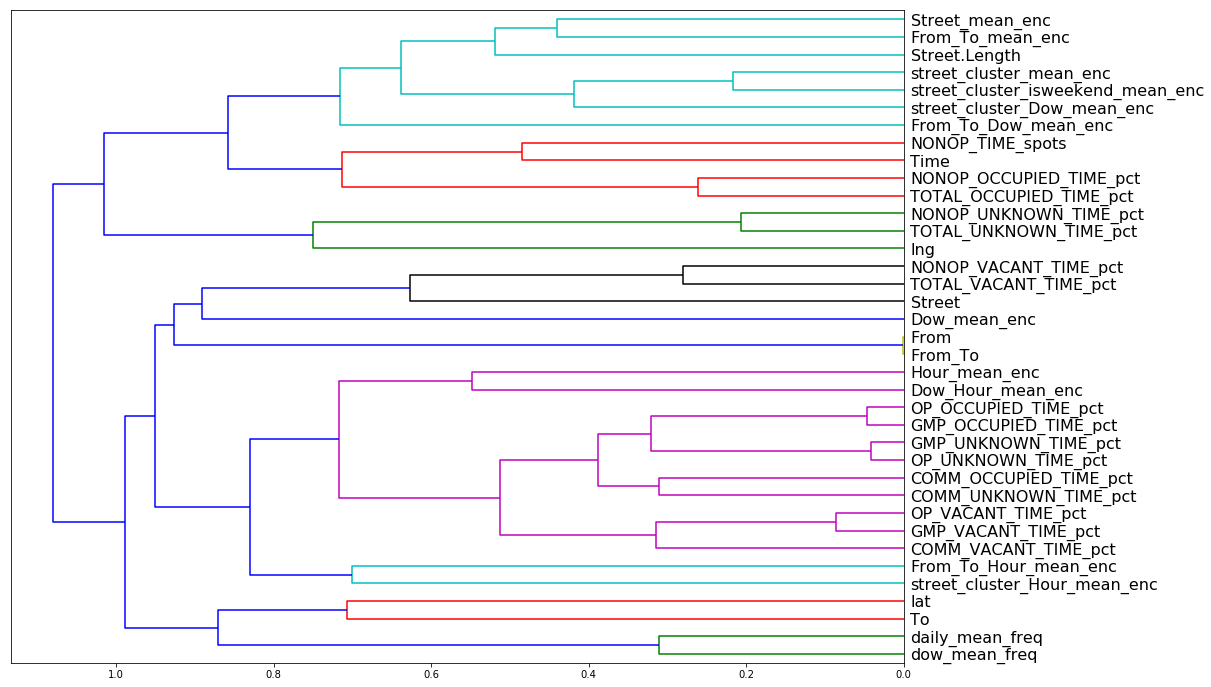

In [96]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,12))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [377]:
def get_oob(df):
    best = (80, 15, 0.8, 1.3)
    np.random.seed(42)
    m = RandomForestClassifier(n_estimators = best[0], max_depth =best[1], max_features=best[2], class_weight={0:1,1:best[3]}, min_samples_split = 2, n_jobs=-1,oob_score=True)
    m.fit(df, y_train_swhg)
    p = m.predict(X_valid_swhg[df.columns])
    f1 = f05_score_hard(y_valid_swhg, p)
    return m.oob_score_,f1

In [378]:
get_oob(df_keep)

(0.72457627118644063, 0.48076923076923073)

In [379]:
df_keep.columns

Index(['From_To_mean_enc', 'Time', 'Street.Length', 'dow_mean_freq',
       'TOTAL_VACANT_TIME_pct', 'Dow_Hour_mean_enc', 'TOTAL_OCCUPIED_TIME_pct',
       'To', 'Hour_mean_enc', 'From_To_Dow_mean_enc',
       'street_cluster_Dow_mean_enc', 'street_cluster_Hour_mean_enc', 'lat',
       'lng', 'TOTAL_UNKNOWN_TIME_pct', 'daily_mean_freq',
       'NONOP_OCCUPIED_TIME_pct', 'NONOP_VACANT_TIME_pct', 'Dow_mean_enc',
       'street_cluster_isweekend_mean_enc', 'From_To', 'OP_UNKNOWN_TIME_pct',
       'From_To_Hour_mean_enc', 'Street_mean_enc', 'GMP_VACANT_TIME_pct',
       'GMP_UNKNOWN_TIME_pct', 'street_cluster_mean_enc',
       'NONOP_UNKNOWN_TIME_pct', 'COMM_UNKNOWN_TIME_pct',
       'COMM_OCCUPIED_TIME_pct', 'From', 'Street', 'GMP_OCCUPIED_TIME_pct',
       'OP_VACANT_TIME_pct', 'COMM_VACANT_TIME_pct', 'OP_OCCUPIED_TIME_pct',
       'NONOP_TIME_spots'],
      dtype='object')

In [386]:
#'From_To_realspot_enc','Street_realspot_enc','From_To_Hour_realspot_enc'
for c in ('GMP_OCCUPIED_TIME_pct','To','Dow_mean_enc','From_To_Dow_mean_enc','OP_VACANT_TIME_pct','OP_UNKNOWN_TIME_pct'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

GMP_OCCUPIED_TIME_pct (0.7298728813559322, 0.54878048780487809)
To (0.72669491525423724, 0.52777777777777768)
Dow_mean_enc (0.72881355932203384, 0.5232558139534883)
From_To_Dow_mean_enc (0.71504237288135597, 0.53125)
OP_VACANT_TIME_pct (0.71927966101694918, 0.53977272727272718)
OP_UNKNOWN_TIME_pct (0.71292372881355937, 0.5)


In [381]:
droplist = ['GMP_OCCUPIED_TIME_pct','To','Dow_mean_enc','From_To_Dow_mean_enc','OP_VACANT_TIME_pct','OP_UNKNOWN_TIME_pct']

### Rerun Grid Search to find parameters after dropping features

In [382]:
finalkeep = df_keep.drop(droplist, axis = 1)

In [383]:
finalval = X_valid_swhg[finalkeep.columns]

In [384]:
parameters = []
f05 = []
precision = []
recall = []

for p in combo:
    np.random.seed(42)
    m = RandomForestClassifier(n_estimators = p[0], max_depth =p[1], max_features=p[2],class_weight={0:1,1:p[3]}, min_samples_split = 2, n_jobs=-1)
    m.fit(finalkeep,y_train_swhg)
    pred = m.predict(finalval)
    prec = precision_score(y_valid_swhg, pred)
    rec = recall_score(y_valid_swhg, pred)
    f = f05_score_hard(y_valid_swhg, pred)
    parameters.append(p)
    f05.append(f)
    precision.append(prec)
    recall.append(rec)

table4 = pd.DataFrame({'Parameters': parameters, 'f0.5': f05, 'precision':precision, 'recall':recall})

In [385]:
table4.sort_values('f0.5', ascending=False, inplace=True)
table4.head()

,Parameters,f0.5,precision,recall
195,"(20, 15, 0.2, 1.3)",0.592105,0.720000,0.346154
759,"(40, 25, 0.2, 1)",0.579268,0.678571,0.365385
822,"(40, 30, 0.2, 1)",0.579268,0.678571,0.365385
686,"(40, 15, 1, 0.9)",0.576923,0.692308,0.346154
714,"(40, 20, 0.5, 1)",0.565476,0.655172,0.365385


In [425]:
best = (20, 15, 0.2, 1.3)
np.random.seed(42)
m3 = RandomForestClassifier(n_estimators = best[0], max_depth =best[1], max_features=best[2], class_weight={0:1,1:best[3]}, min_samples_split = 2, n_jobs=-1)
m3.fit(finalkeep,y_train_swhg)
pred = m3.predict(finalval)
soft=m3.predict_proba(finalval)
prec = precision_score(y_valid_swhg, pred)
rec = recall_score(y_valid_swhg, pred)
f = f05_score_hard(y_valid_swhg, pred)
print (f)    
feat_imp_swhg = pd.DataFrame({
    'features': finalval.columns,
    'imp' :m3.feature_importances_
})
feat_imp_swhg.sort_values(by='imp', inplace=True, ascending=False)

0.592105263158


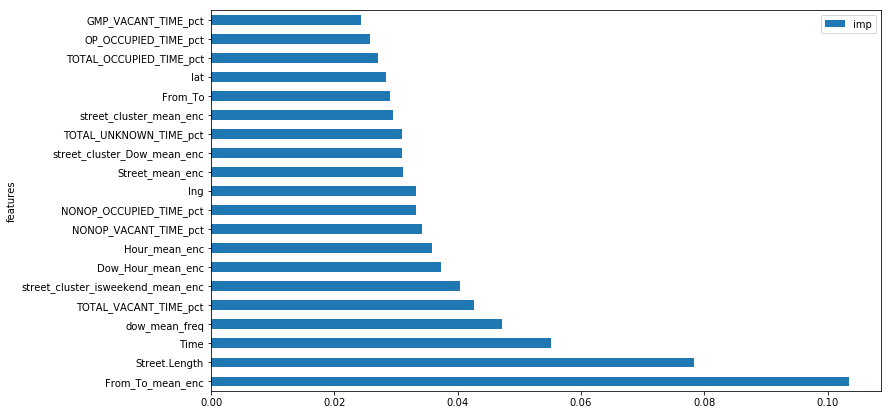

In [396]:
import matplotlib.pyplot as plt
%matplotlib inline
feat_imp_swhg[:20].plot('features','imp','barh', figsize=(12,7))

In [309]:
finalfeatures = finalkeep.columns

### Try XGBOOST and Ensembe XGBoost and RF

In [409]:
dtrain = xgb.DMatrix(X_train_swhg, label=y_train_swhg)
dval= xgb.DMatrix(X_valid_swhg, label=y_valid_swhg)

params = {
    'eta': 0.001,
    'max_depth':15,
    'min_child_weight': 1,
    'subsample': 0.8,
    'objective':'binary:logistic',
    'colsample_bytree':0.6,
    "eval_metric" : ['logloss','auc']
}

watchlist = [(dtrain, 'train'), (dval, 'val')]
bst_bow = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=150, verbose_eval=50)

clf = xgb.train(params, dtrain, num_boost_round=bst_bow.best_ntree_limit-1)

out = clf.predict(dval)
pred = out>0.5

f05_score_hard(y_valid_swhg, pred)

[0]	train-logloss:0.692654	train-auc:0.893458	val-logloss:0.692906	val-auc:0.650333
Multiple eval metrics have been passed: 'val-auc' will be used for early stopping.

Will train until val-auc hasn't improved in 150 rounds.
[50]	train-logloss:0.670659	train-auc:0.980391	val-logloss:0.682804	val-auc:0.683987
[100]	train-logloss:0.64992	train-auc:0.981749	val-logloss:0.67378	val-auc:0.678254
[150]	train-logloss:0.630253	train-auc:0.9825	val-logloss:0.665589	val-auc:0.674926
Stopping. Best iteration:
[3]	train-logloss:0.691294	train-auc:0.954246	val-logloss:0.692172	val-auc:0.70895



0.53191489361702138

In [421]:
out2=(out*0.5+soft[:,1]*0.5)>0.5
f05_score_hard(y_valid_swhg, out2)

0.59210526315789458

### DOW-retrain entire model - remember to drop insignificant columns in the end

In [310]:
train = pd.merge(train,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])
test= pd.merge(test,st_latlng,how ='left',left_on=["Street","From","To"], right_on=["Street","From","To"])

spots = np.vstack(train[['lat','lng']].values)
kmeans = KMeans().fit(spots)
train['street_cluster'] = kmeans.predict(train[['lat', 'lng']])
test['street_cluster'] = kmeans.predict(test[['lat', 'lng']])

In [311]:
train['Minute'] = train.Date_Time.dt.minute
test['Minute'] = pd.to_datetime(test['Date_Time']).dt.minute
train['Hour'] = train.Date_Time.dt.hour
test['Hour'] = pd.to_datetime(test['Date_Time']).dt.hour
train['Dow'] = train.Date_Time.dt.weekday
test['Dow'] = pd.to_datetime(test['Date_Time']).dt.weekday

In [312]:
train['Time'] = train["Hour"]*100 + train['Minute']
test['Time'] = test["Hour"]*100 + test['Minute']
train['isweekend'] = train['Dow'].apply(day_type)
test['isweekend'] = test['Dow'].apply(day_type)
train['From_To'] = train['From'] + '_' + train['To']
test['From_To'] = test['From'] + '_' + test['To']

In [313]:
cols = ['Dow','isweekend','From_To','Street','Hour', 'street_cluster' ]
multi_reg_mean_encoding(train, cols, splits =5)
multi_test_mean_encoding(test, train, cols)

In [314]:
colpairs = [('street_cluster','Dow'),('Dow','Hour'), ('street_cluster','Hour'),
            ('street_cluster','isweekend'),('From_To','Dow'),('From_To','Hour')]
pairlist = []
for pair in colpairs:
    colname = pair[0] + '_' + pair[1]
    pairlist.append(colname)
    train[colname] = list(zip(train[pair[0]], train[pair[1]]))
    test[colname] = list(zip(test[pair[0]], test[pair[1]]))

In [315]:
multi_reg_mean_encoding(train, pairlist, splits =5)
multi_test_mean_encoding(test, train, pairlist)

In [316]:
pairlist2= ['Street','From_To','street_cluster_Hour','street_cluster_isweekend','From_To_Dow','From_To_Hour']
realspot_mean_encoding(train, pairlist2, splits =5)
realspot_test_mean_encoding(test, train, pairlist2)

In [317]:
train = train.drop(['Date_Time','Real.Spots', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis =1)
test = test.drop(['Date_Time', 'street_cluster_Dow', 'Dow_Hour', 'street_cluster_Hour', 'street_cluster_isweekend', 'From_To_Dow', 'From_To_Hour'], axis = 1)

In [318]:
train['Street'] = train.Street.str.lower()
train['From'] = train.From.str.lower()
train['To'] = train.To.str.lower()
test['Street'] = test.Street.str.lower()
test['From'] = test.From.str.lower()
test['To'] = test.To.str.lower()

In [319]:
train = pd.merge(train,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])
test = pd.merge(test,sensor, how='left',left_on=['Street','Dow','Hour'], right_on=['STREET_NAME','DOW','TIME_OF_DAY'])

train = train.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)
test = test.drop(['STREET_NAME','DOW','TIME_OF_DAY'],axis =1)

In [320]:
catcols = ['Street','From','To', 'From_To']
train,test = process_dfs(train.copy(),test.copy(),catcols)
train,test = cat2code(train,test,catcols)

In [321]:
X_train,y_train = split_response(train.copy(),'any_spot')

In [324]:
#only use selected features
X_train = X_train[list(finalfeatures)]
test = test[list(finalfeatures)]

In [326]:
# Fit rf
np.random.seed(42)
m_swhg = RandomForestClassifier(n_estimators = 40, max_depth =10, max_features=0.8, class_weight={0:1,1:1.3}, min_samples_split = 2, n_jobs=-1)
m_swhg.fit(X_train,y_train)
pred_swhg_prob = m_swhg.predict_proba(test)
pred_swhg = m_swhg.predict(test)

In [200]:
result = pd.DataFrame({"id": np.arange(1,len(test)+1),"any_spot":pred_swhg})

In [201]:
result[['id','any_spot']].to_csv("../submissions/36_4.csv", index =False)

### Xgboost Model

In [322]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest= xgb.DMatrix(test)

params = {
    'eta': 0.001,
    'max_depth':20,
    'min_child_weight': 1,
    'subsample': 0.8,
    'objective':'binary:logistic',
    'colsample_bytree':0.6,
    "eval_metric" : ['logloss','auc']
}

clf = xgb.train(params, dtrain, num_boost_round=79)

In [323]:
predxgb = clf.predict(dtest)
predxgb1 = clf.predict(dtest)>0.5

In [331]:
result = pd.DataFrame({"id": np.arange(1,len(test)+1),"any_spot":predxgb1})

In [332]:
result[['id','any_spot']].to_csv("../submissions/xgb2.csv", index =False)

### Ensemble Xgboost and RF

In [327]:
#soft prediction from RF
p_rf= pred_swhg_prob[:,1]

In [328]:
#get average
avg = (p_rf + predxgb)/2
avg_hard = (avg>=0.5)

In [330]:
result = pd.DataFrame({"id": np.arange(1,len(test)+1),"any_spot":predxgb1})
result[['id','any_spot']].to_csv("../submissions/en_rf_xgb2.csv", index =False)

array([False, False, False,  True, False, False, False, False,  True,
       False,  True,  True,  True, False, False, False,  True,  True,
       False, False, False, False,  True,  True,  True,  True, False,
       False, False, False, False, False, False,  True, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False,  True,  True,  True, False,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False,  True,